# 0.0 IMPORTS

In [1]:
# Database and Operations
import pandas as pd
import numpy as np
import math

import inflection
import pickle

# Visual
import seaborn as sns
import matplotlib.pyplot as plt

# System
import sys

# ML & Metrics
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

import xgboost as xgb
from boruta import BorutaPy

# Random 
import random

# Performance
from IPython.core.display import Image,display
from IPython.core.display import HTML
import datetime 
import warnings
from tabulate import tabulate

# Web 
from flask import Flask, request, Response
import requests

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [3]:
# cramer's v correlation
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values 
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr/n ) / min( kcorr-1, rcorr-1 ))

# mape 
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) /  y ) )

# machine learning error metrics
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'MODEL NAME' : model_name, 
                           'MAE' : mae, 
                           'MAPE' : mape, 
                           'RMSE' : rmse }, index=[0] )


# makes de cross validation for a given model
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    # creates empty lists to store the metrics
    mae_list = []
    mape_list = []
    rmse_list = []

    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # final date minus 6 weeks
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 7 * 6)

        # final date
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1) * 7 * 6)

        # filters dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # traning and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation= validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m_regression = model.fit(xtraining, ytraining)

        # prediction
        yhat = m_regression.predict(xvalidation)

        # performance
        regression_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # stores the performance of each KFold iteration
        mae_list.append(regression_result['MAE'])
        mape_list.append(regression_result['MAPE'])
        rmse_list.append(regression_result['RMSE'])

    # calculates the mean from the errors : the real metric for the algorithm
    # and creates a DataFrame to organize the data
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                       index=[0])



In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [6]:
# sales and store data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRIPTION OF THE DATA

In [7]:
# create a data checkpoint
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
# old columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# creates a "snakecase function" to transform the column names to snakecase 
snakecase = lambda x: inflection.underscore( x )

# new columns
cols_new = list( map( snakecase, cols_old ) )

# rename columns
df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
# check the number of rows
print( 'number of rows: {}'.format( df1.shape[0] ) )

# check the number of columns
print( 'number of cols: {}'.format( df1.shape[1] ) )

number of rows: 1017209
number of cols: 18


## 1.3 Data Types

In [10]:
# change date column type to datetime
df1[ 'date' ] = pd.to_datetime( df1[ 'date' ] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
# check for NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

The presence of missing data is perceived. We can solve the "NA's" in 3 ways:

**1. Delete the missing data:** It is a quick method, but we can lose a lot of information that can affect the performance of the machine learning algorithms.

**2. Replace the missing data with Machine Learning:** This method is good when we have little or no information about the business.
 
**3. Replace the missing data with relevant information about the business:** Method of greater fidelity to the behavior of the data. Good when we have enough information about the business.

We must choose the most efficient method for the situation based on the amount of time and information available. In this case, I will replace the missing data with method 3.

#### Data Fields from Rossmann for better understanding of the business

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.5 Fillout NA

In [12]:
# checking the maximum distance between the nearest competitor
df1['competition_distance'].max()

75860.0

In [13]:
# Treating null data following a business logic

# competition_distance:
# For the null data of the distance between competitors, 
# let's assume that in fact the distance is so great that there are no competitors nearby. 
# Let's assume a distance value of 200000 if is nan
df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month:
# For the null data of the competition open since month, 
# we will replace the null data with the sale date (month)
df1[ 'competition_open_since_month' ] = df1.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ], axis=1 )

# competition_open_since_year 
df1[ 'competition_open_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ], axis=1 )
                         
# promo2_since_week 
df1[ 'promo2_since_week' ] = df1.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ], axis=1 )
   
# promo2_since_year 
df1[ 'promo2_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ], axis=1 )

# promo_interval
# dictionary for a better reading of the months 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1[ 'promo_interval' ].fillna( 0, inplace=True )

# we will create a 'month_map' column as the mapping of the column 'date'  
df1[ 'month_map' ] = df1[ 'date' ].dt.month.map( month_map )

# creates a 'is_promo' column that points to
# 1 if 'month_map' is in 'promo_interval' (has promo)
# or 0 if 'promo_interval' == 0 or else
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x[ 'promo_interval' ] == 0 else 1 if x[ 'month_map' ] in x[ 'promo_interval' ].split( ',' ) else 0, axis=1 )


In [14]:
# checking for any missing data
# no more NAN's
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [15]:
# check in Transpose, for better visualization of recent actions
df1.sample(5).T

,598119,721068,520445,714996,66100
store,150,449,526,1067,316
day_of_week,6,1,6,7,2
date,2014-01-11 00:00:00,2013-09-23 00:00:00,2014-03-22 00:00:00,2013-09-29 00:00:00,2015-06-02 00:00:00
sales,7444,13580,7860,0,13764
customers,814,1727,1171,0,1062
open,1,1,1,0,1
promo,0,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,a,d,d


## 1.6 Change Types

In [16]:
# checking data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# it is noticed that the columns: 
# 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week'
# and 'promo2_since_year', are in float. 
# However, these columns are better represented in int, since they are discrete temporal data (month, year, week)

# therefore, we will make a change in the data types: float64 to int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')  
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [18]:
# checking data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In this step we will use a little descriptive statistics mainly for:

1. Gain business knowledge
2. Detect Errors and Anomalies

There are 2 major metrics in Descriptive statistics

1. **Central Tendency** (Mean and Median mainly play a role of summarizing all data in single values)
2. **Dispersion** (Variance, Min and Max, Skew, Kurtosis and Standard Deviation will help to find out "the shape" and how sparse the data is around the mean)

for that, we must then:

In [19]:
# first step: separate the data into numeric and categorical variables

# numeric data
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64' ] )

# categorical data
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]' ] )

cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
745528,0,d,a,0,Sep
693065,0,c,c,"Mar,Jun,Sept,Dec",Oct


### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate all numeric metrics in a single dataframe
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skw', 'kurtosis'  ] 

In [21]:
# check numeric metrics
m

,attributes,min,max,range,mean,median,std,skw,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

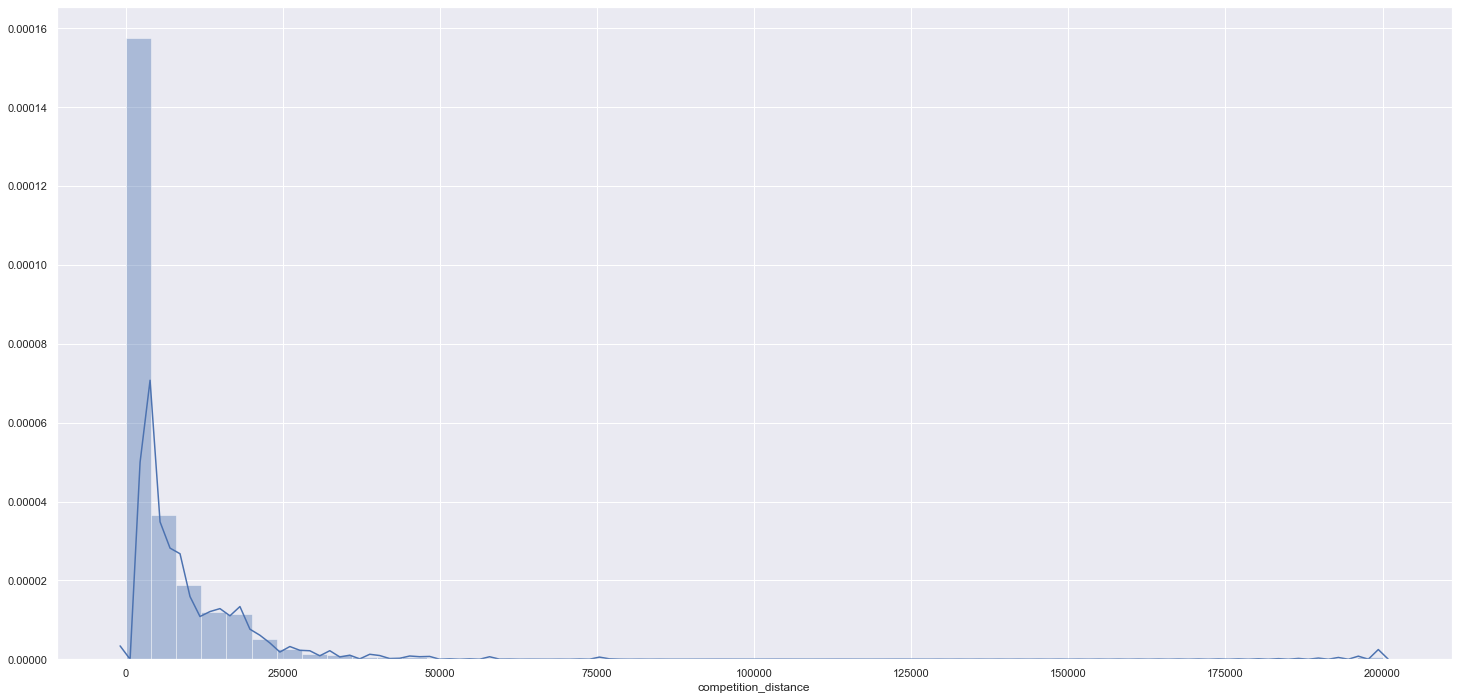

In [22]:
# check distribution
sns.distplot( df1[ 'competition_distance' ] )

Competition distance has a high positive skew and kurtosis

* this means that most competing stores are close

### 1.7.2 Categorical Attributes

In [23]:
# check categorical data 
cat_attributes.apply( lambda x: x.unique().shape[0] ) 

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

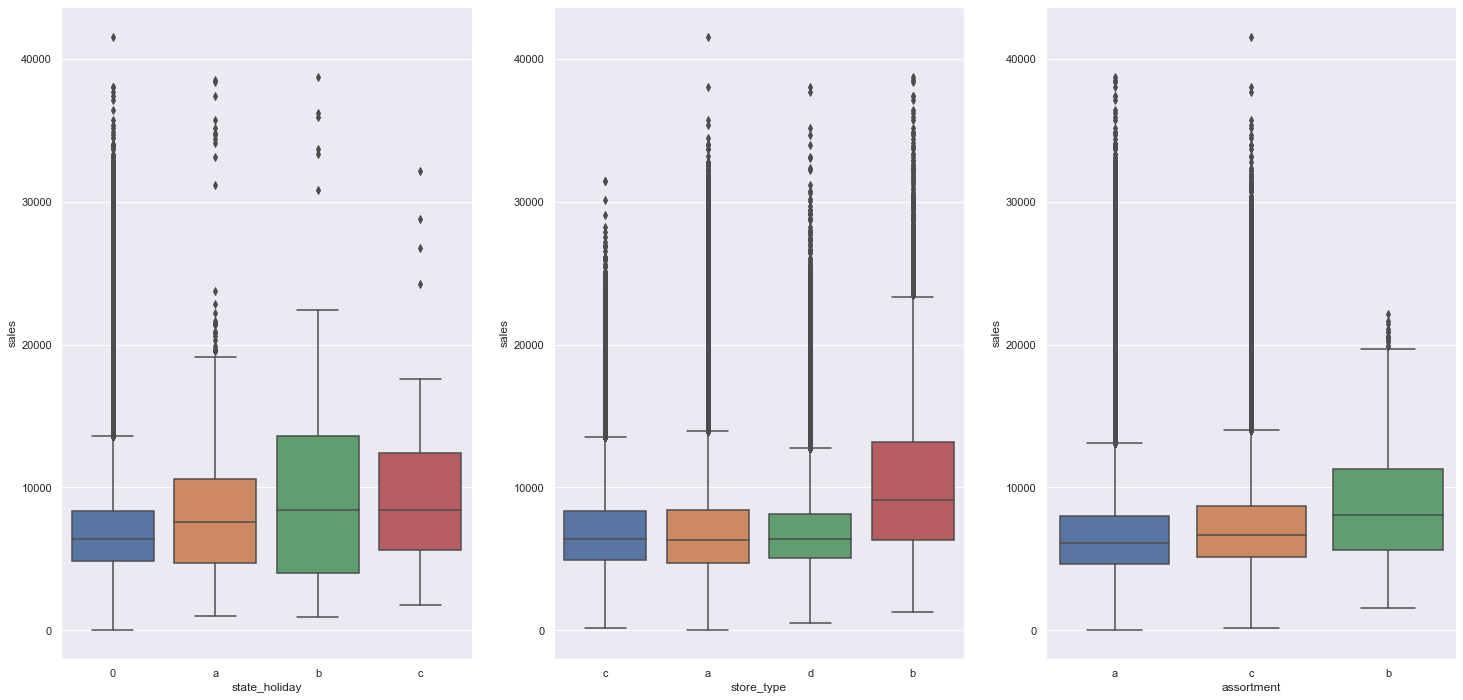

In [24]:
# we will use boxplot for categorical data representation:
# As the data are very different, the boxplot is too dispersed
# filtering on state_holiday! = 0 and sales > 0 it balances the size of the chart
aux1 = df1[ ( [ 'state_holiday' ] != 0 ) & ( df1[ 'sales' ] > 0 ) ]

# subplot 1 - state holiday
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

# subplot 2 - store type
plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

# subplot 3 - assortment
plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 FEATURE ENGINEERING 

In [25]:
# data checkpoint
df2 = df1.copy()

## Mind Map

In this step, we will focus on creating hypotheses to gain a better understanding of the business

* Therefore, we will create a mind map, as a kind of brainstorm, to organize our Prior

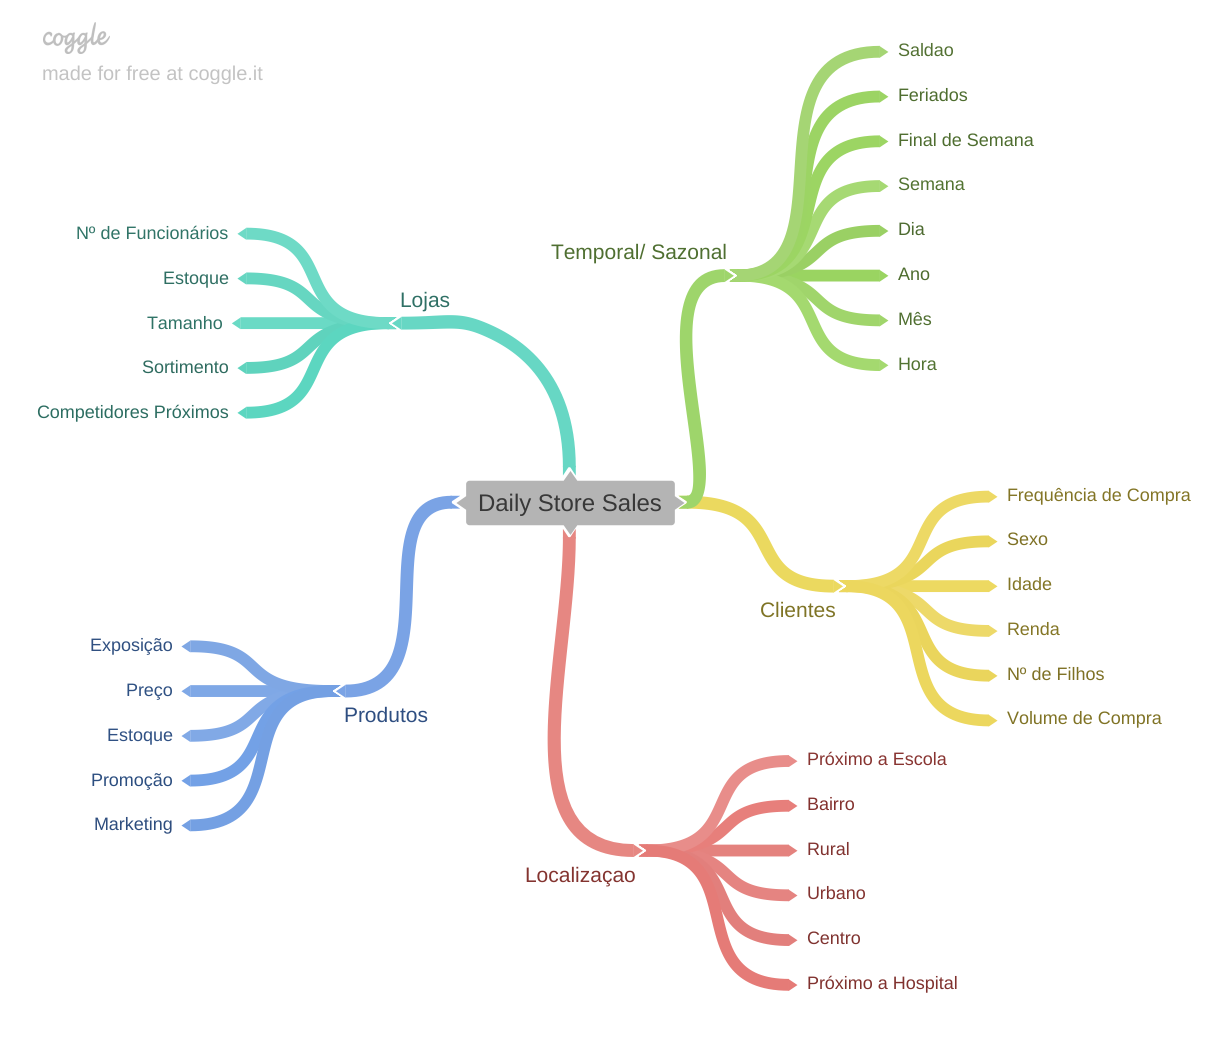

In [26]:
# display image of mind map
Image('img/mindmap_hypotesis.png')

## 2.1 Creating Hypothesis 

### 2.1.1 Store Hypotesis

**1.** Stores with a larger workforce sell / or should sell more

**2.** Stores with higher inventory sell / or should sell more

**3.** Larger stores sell / or should sell more

**4.** Smaller stores sell / or should sell less

**5.** Stores with a larger assortment should sell more

### 2.1.2 Product Hypotesis

**1.** Stores that invest more in Marketing should sell more

**2.** Stores that exhibit the product more in store windows should sell more

**3.** Stores that have lower product prices should sell more

**4.** Stores that have had lower prices for longer should sell more

### 2.1.3 Time Hypotesis

**1.** Stores that go on more holidays should sell less

**2.** Stores that open in the first 6 months should sell more

**3.** Stores that open on weekends should sell more

## 2.2 Final List of Hypotheses (Priorities)

Since we are following the CRISP method, we will focus on completing the first round  of the method, adding value quickly to the project.

* We will prioritize some hypotheses over others, taking into account the data we already have available.

* If the hypotheses we choose do not bring the desired performance later, we will do a second round of CRISP for better performance.

### Hypotesis List

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with longer competitors should sell more

**4.** Stores with longer active promotions should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores open during the Christmas holiday should sell more

**8.** Stores that open in the first 6 months should sell more

**9.** Stores that open on weekends should sell more

**10.** Stores should sell more over the years

**11.** Stores should sell more in the second half of the year

**12.** Stores should sell more after the 10th of each month

**13.** Stores should sell less on weekends

**14.** Stores should sell less during school holidays

## 2.3 Feature Engineering

In this step, we will enter the feature engineering process
to derive some important variables for the validation of our hypotheses 

In [27]:
# New variables to be created
# year
df2[ 'year' ] = df2[ 'date' ].dt.year

# month 
df2[ 'month' ] = df2[ 'date' ].dt.month

# day
df2[ 'day' ] = df2[ 'date' ].dt.day

# week of year
df2[ 'week_of_year' ] = df2[ 'date' ].dt.weekofyear

# year week
df2[ 'year_week' ] = df2[ 'date' ].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since' ] = df2.apply( lambda x: datetime.datetime(year=x[ 'competition_open_since_year' ], month=x[ 'competition_open_since_month' ], day=1), axis=1 )
df2[ 'competition_time_month' ] = ( ( df2[ 'date' ] - df2[ 'competition_since' ] ) / 30 ).apply( lambda x: x.days).astype( 'int64' )

# promo since
df2[ 'promo_since' ] = df2[ 'promo2_since_year' ].astype( str ) + '-' + df2[ 'promo2_since_week' ].astype( str )
df2[ 'promo_since' ] = df2[ 'promo_since' ].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2[ 'promo_time_week' ] = ( ( df2[ 'date' ] - df2[ 'promo_since' ] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2[ 'assortment' ] = df2[ 'assortment' ].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2[ 'state_holiday' ] = df2[ 'state_holiday' ].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

df2.head().T


,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTERING VARIABLES

As some columns have undergone changes and derivations, this step is intended to clean and organize
the resulting Dataframe in order to bring better convenience and performance to the data analysis.

In [28]:
# data checkpoint
df3 = df2.copy()

## 3.1 Row Filtering

As we will only analyze stores that are opened and have sales: 
* we filter stores where 'open' is different than zero (open) and sales are greater than zero

In [29]:
# filtering only by opened and has sales greater than zero
df3 = df3[ ( df3[ 'open' ] != 0 ) & ( df3[ 'sales' ] > 0 ) ]

## 3.2 Column Selection

* We don't have the number of costumers, so this is a restriction to the model now
* As we only chose opened stores and, now everything is equal to 1, it doesn't make sense to have the column 'open' anymore
* 'promo_interval' and 'month_map' are no longer needed, as we have already derived the resources we needed

In [30]:
# Drop this columns as they lost relevance for the analysis
drop_cols = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( drop_cols, axis=1 )

In [31]:
# check columns
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

In this step we will focus on visualize the impact of the predictors variables in the outcome to:
* Gain business knowledge
* Conclude hypotesis validation and generate insights

In this way, we create an anticipated understanding of which variables can perform best to predict the sales, in our prediction model.

In [32]:
# data checkpoint
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

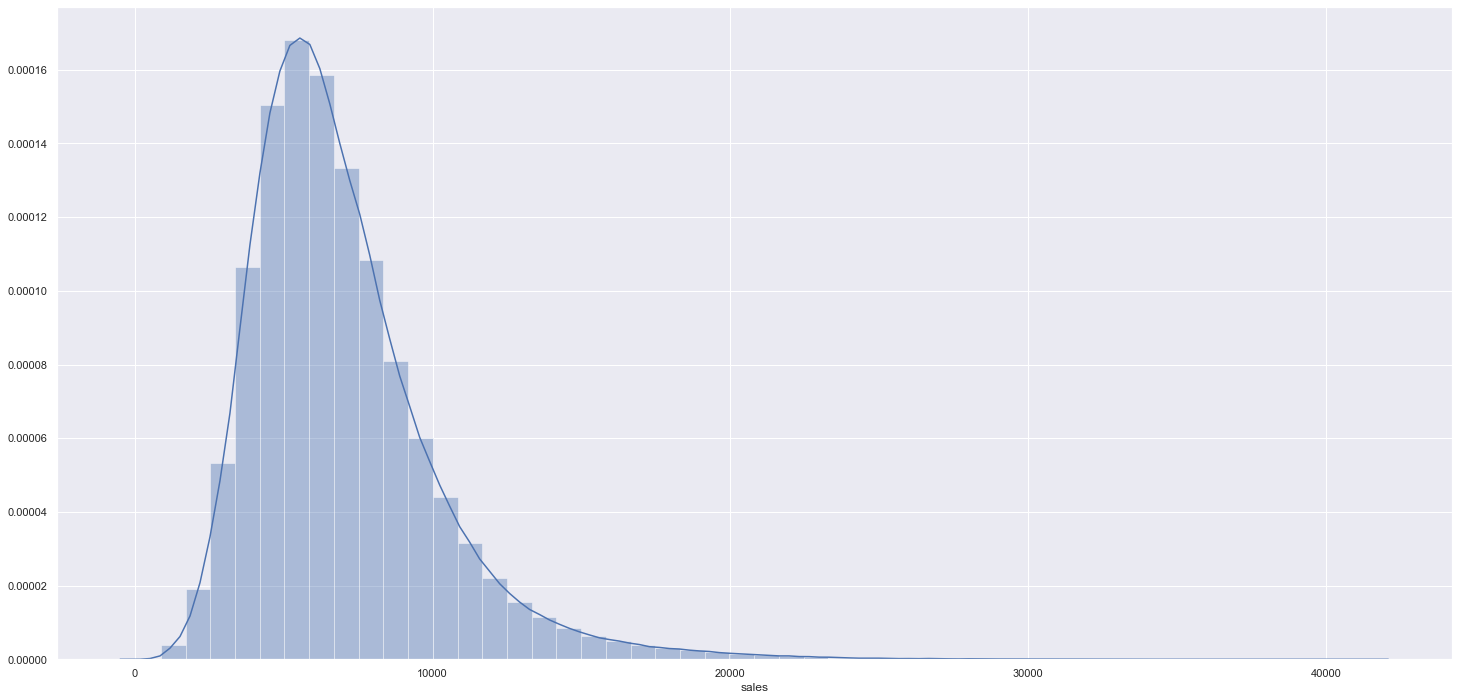

In [33]:
# check distribution of response variable
sns.distplot( df4[ 'sales' ] )

As we can see, the variable is not normally distributed.

For a better calculation of machine learning algorithms, it is advisable that:
* the variables are normally distributed and that they are independent.

So, let's use some techniques to do this.

### 4.1.2 Numerical Variable

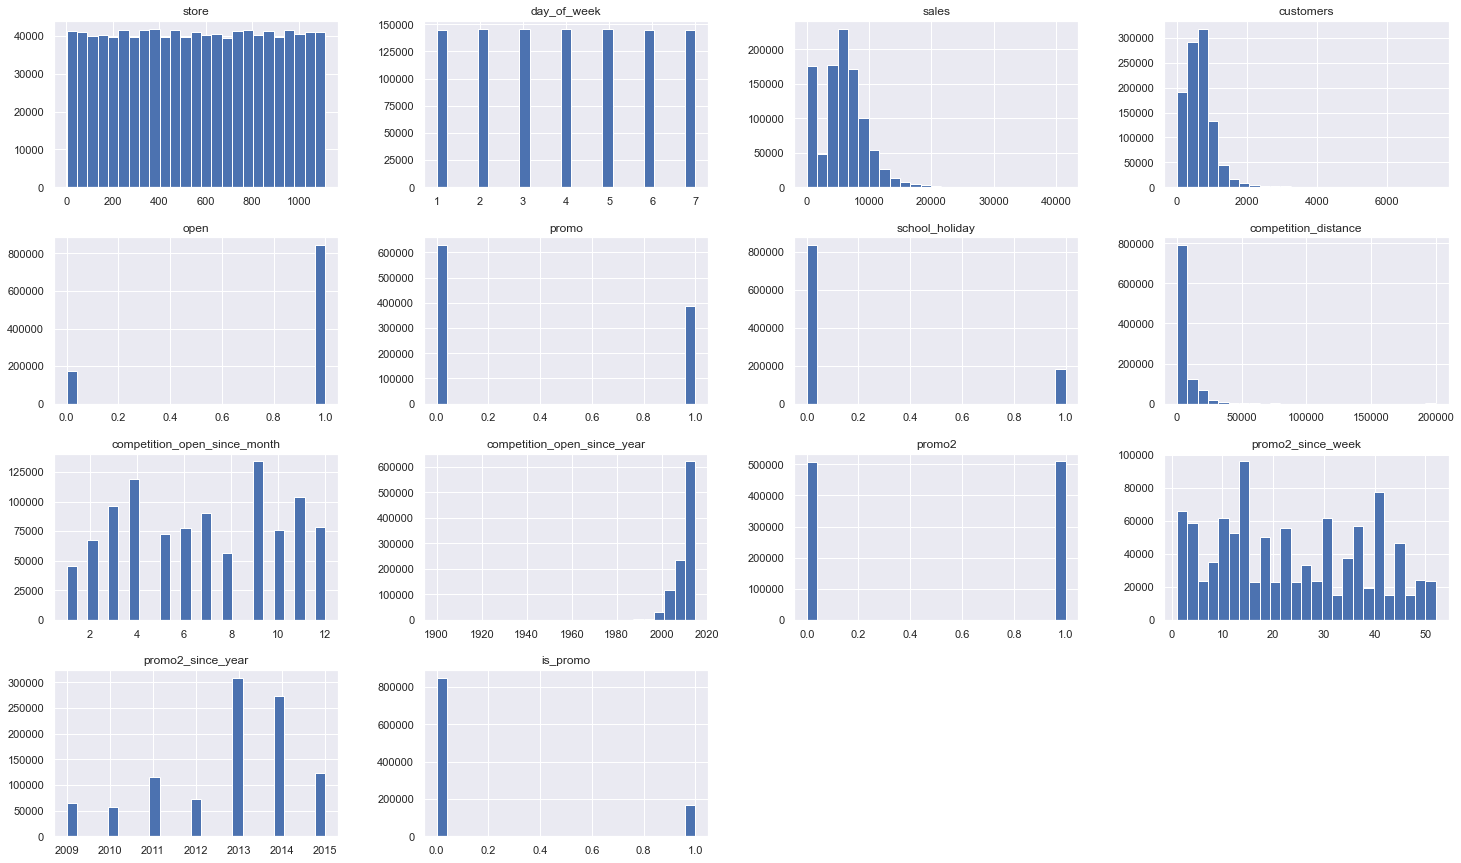

In [34]:
# univariate analysis of numeric variables
num_attributes.hist( bins=25, figsize=(25,15) );

Analysis of the histograms:

* competition_distance: We have more competitors close to the stores, as we can see an increase in the graph in the area close to zero and extending to close to 30000.
* competition_open_since_month: The opening of competing stores seems to have a seasonal behavior.
* competition_open_since_year: There is a salience of the chart close to 2015. This shows that there was more opening of competing stores close to 2015.
* customers: There is a peak of customers close to 1000 and then, a decline. This behavior can be explained due to the opening of new competing stores that started to dispute the same customers, since this variable is related to the number of customers in a given period.
* day_of_week: Distribution is almost uniform. different days of the week do not seem to influence sales much.
* is_promo: we have more sales on days when there is no promotion (0) than on days when there is (1).
* open: There are more stores open (1) than closed (0).
* promo: There are more stores that are not in promotional modality (0) than stores that are (1).
* promo2: There were almost the same number of stores in consecutive promotion.
* promo2_since_week: The data looks a little random and therefore there is not much relevant information apparent.
* promo2_since_year: There is a greater concentration of stores in consecutive promotion in 2013 and then a decline.
* sales: There is a selling range of 0 to almost 20,000 and a peak of around 15,000.
* school_holiday: There are more stores that weren't affected by the closure of public schools (0) than those who were (1).
* store: The variable describes a unique store id. At first this variable does not seem to be relevant to the model.

### 4.1.3 Categorical Variable

In [35]:
# check unique values for 'assortment'
df4[ 'assortment' ].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:>

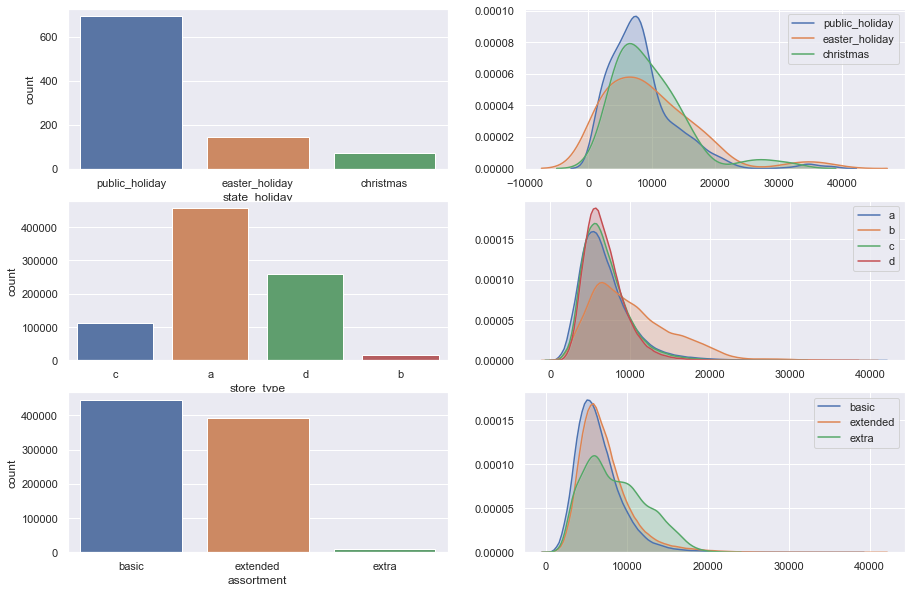

In [36]:
# comparative chart 
# state_holiday
f = plt.figure( figsize=(15,10) )

f.add_subplot( 321 )
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
sns.countplot( a[ 'state_holiday' ] )

f.add_subplot( 322 )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'public_holiday' ]['sales'], label='public_holiday', shade=True  )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'easter_holiday' ]['sales'], label='easter_holiday', shade=True  )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'christmas' ]['sales'], label='christmas', shade=True  )

# store_type

f.add_subplot( 323 )
sns.countplot( df4[ 'store_type' ] )

f.add_subplot( 324 )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'a' ]['sales'], label='a', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'b' ]['sales'], label='b', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'c' ]['sales'], label='c', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'd' ]['sales'], label='d', shade=True  )

# assortment
f.add_subplot( 325 )
sns.countplot( df4[ 'assortment' ] )

f.add_subplot( 326 )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'basic' ]['sales'], label='basic', shade=True  )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extended' ]['sales'], label='extended', shade=True  )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extra' ]['sales'], label='extra', shade=True  )

## 4.2 Bivariate Analysis

#### H1.Stores with a larger assortment should sell more
***False*** Stores with GREATER ASSORTMENT sell LESS.

<AxesSubplot:xlabel='year_week'>

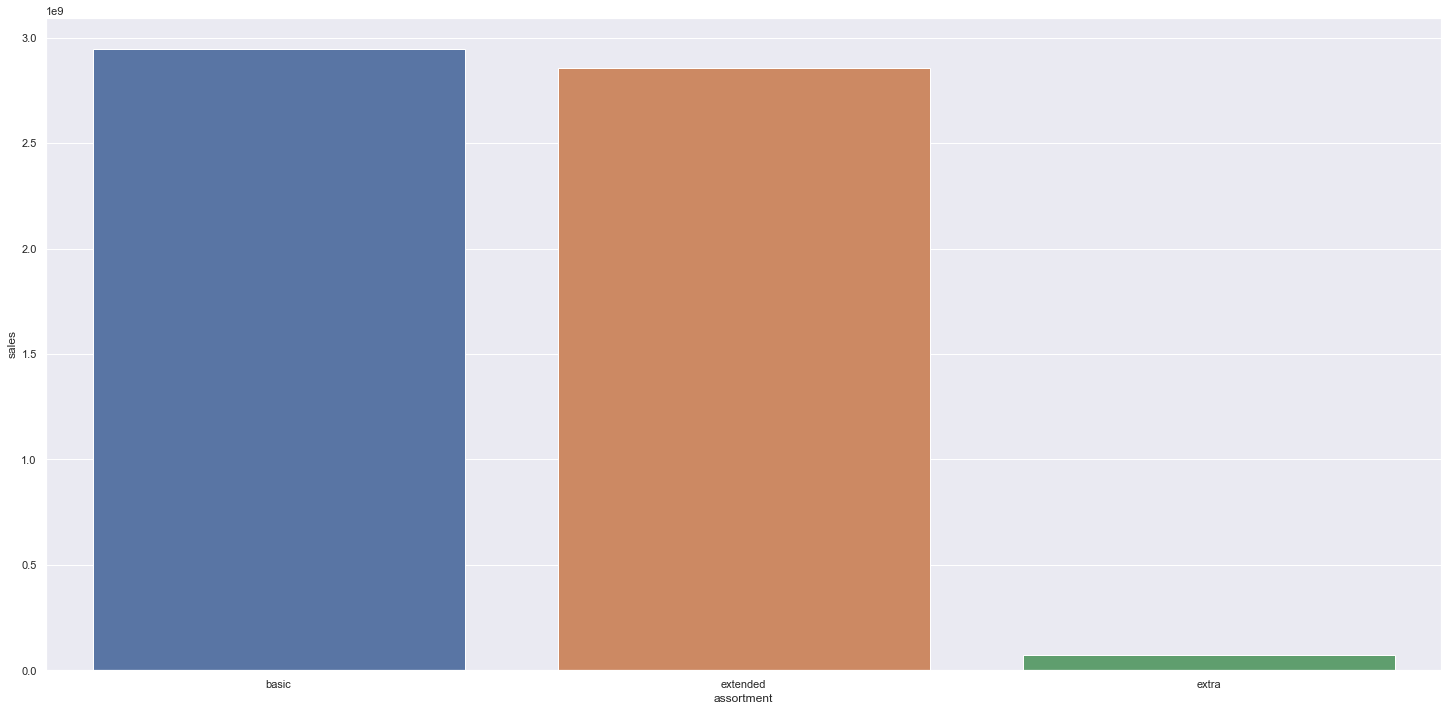

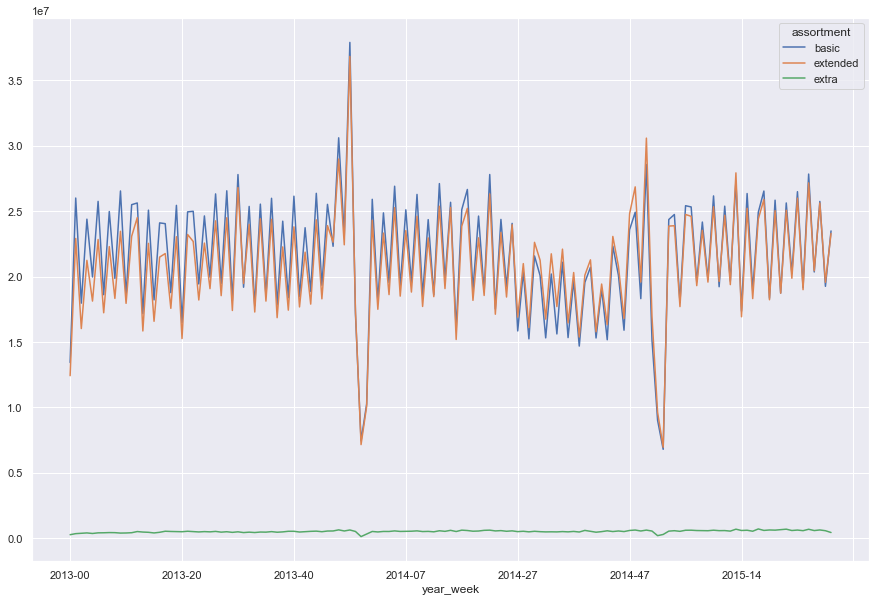

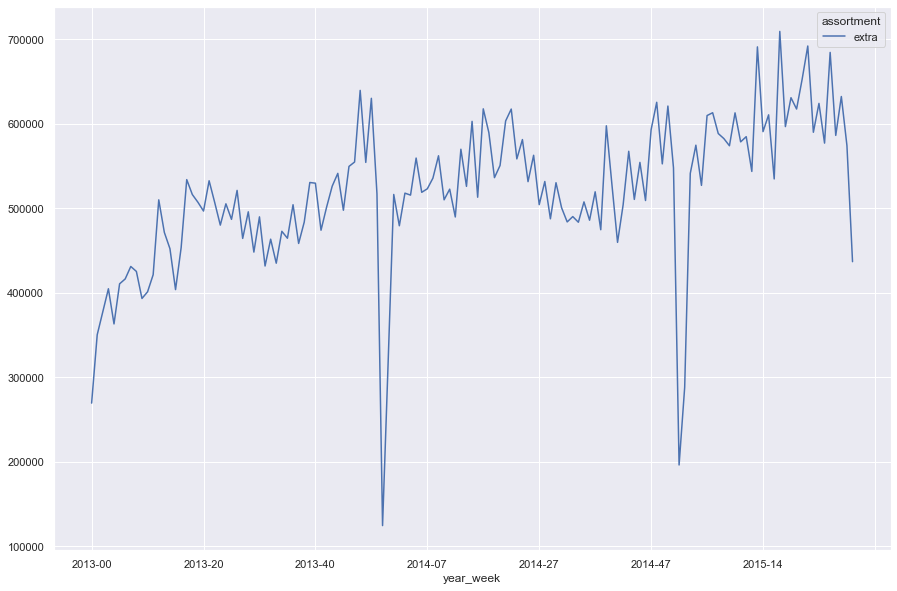

In [37]:
# gets total sales for each assortment
# groupby assortment
aux1 = df4[ [ 'assortment', 'sales' ] ].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# groupby yearweek, assortment
aux2 = df4[ [ 'year_week', 'assortment', 'sales' ] ].groupby( ['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10))

aux3 = aux2[ aux2[ 'assortment' ] == 'extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10))

As we can see, stores with 'basic' assortment has more sales than sales with 'extended' and 'extra'.
'extended' assortment has more sales than 'extra'.

* The greater the assortment, the lower the sales.

#### H2. Stores with closer competitors should sell less
***False*** Stores with NEAREST COMPETITORS sell MORE

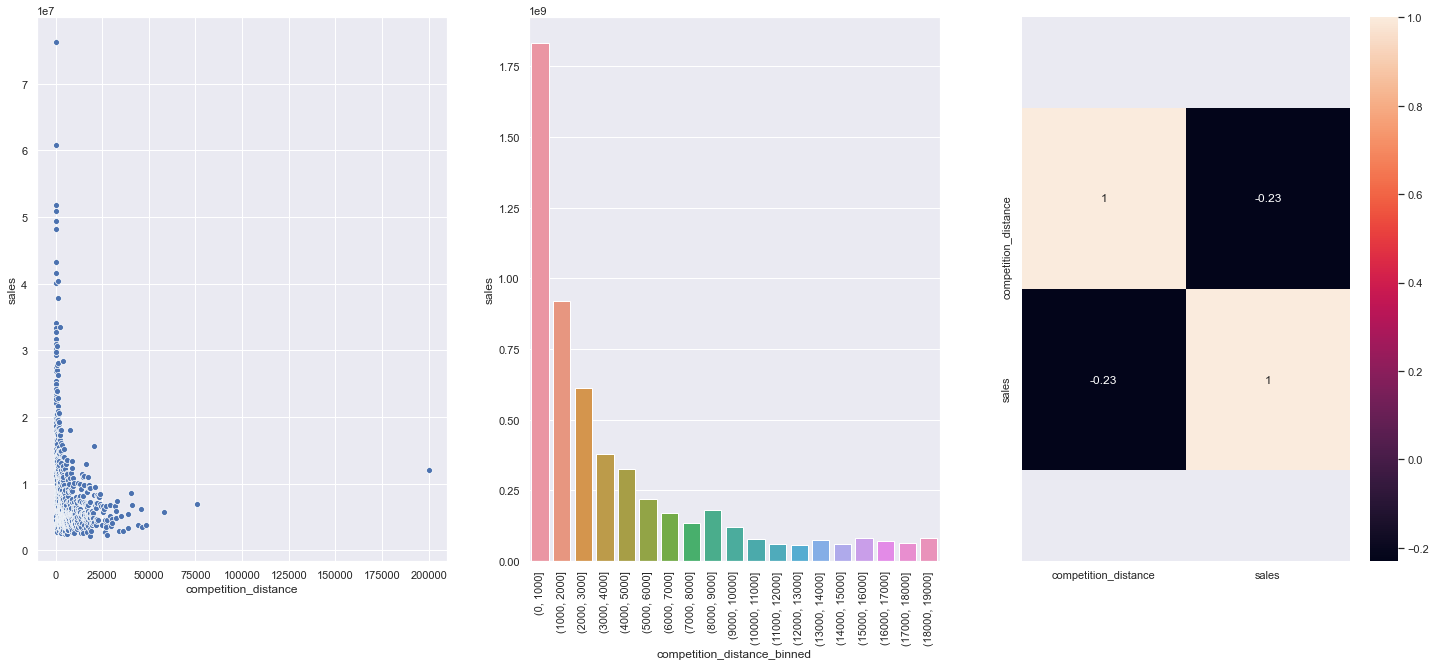

In [38]:
aux1 = df4[ [ 'competition_distance', 'sales' ] ].groupby( 'competition_distance' ).sum().reset_index()

f = plt.figure( figsize=(25,10) )
f.add_subplot( 131 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1);

bins = list( np.arange( 0, 20000, 1000 ) )

aux1[ 'competition_distance_binned' ] = pd.cut( aux1[ 'competition_distance'], bins=bins )
aux2 = aux1[ [ 'competition_distance_binned', 'sales' ] ].groupby( 'competition_distance_binned' ).sum().reset_index()

f.add_subplot( 132 )
#plt.figure( figsize=(30, 10) )
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

f.add_subplot( 133 )
x = sns.heatmap( aux1.corr( 'pearson' ), annot=True )
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

As we can see, especially in the bar chart: 
* (surprisely) stores with nearest competitors, have higher sales.
* There is a weak negative correlation, but we can include it in our model, 
  since it is a variable that somehow influences our sales.

#### H3. Stores with longer competitors should sell more
***False*** Stores with LONGER COMPETITORS sell LESS

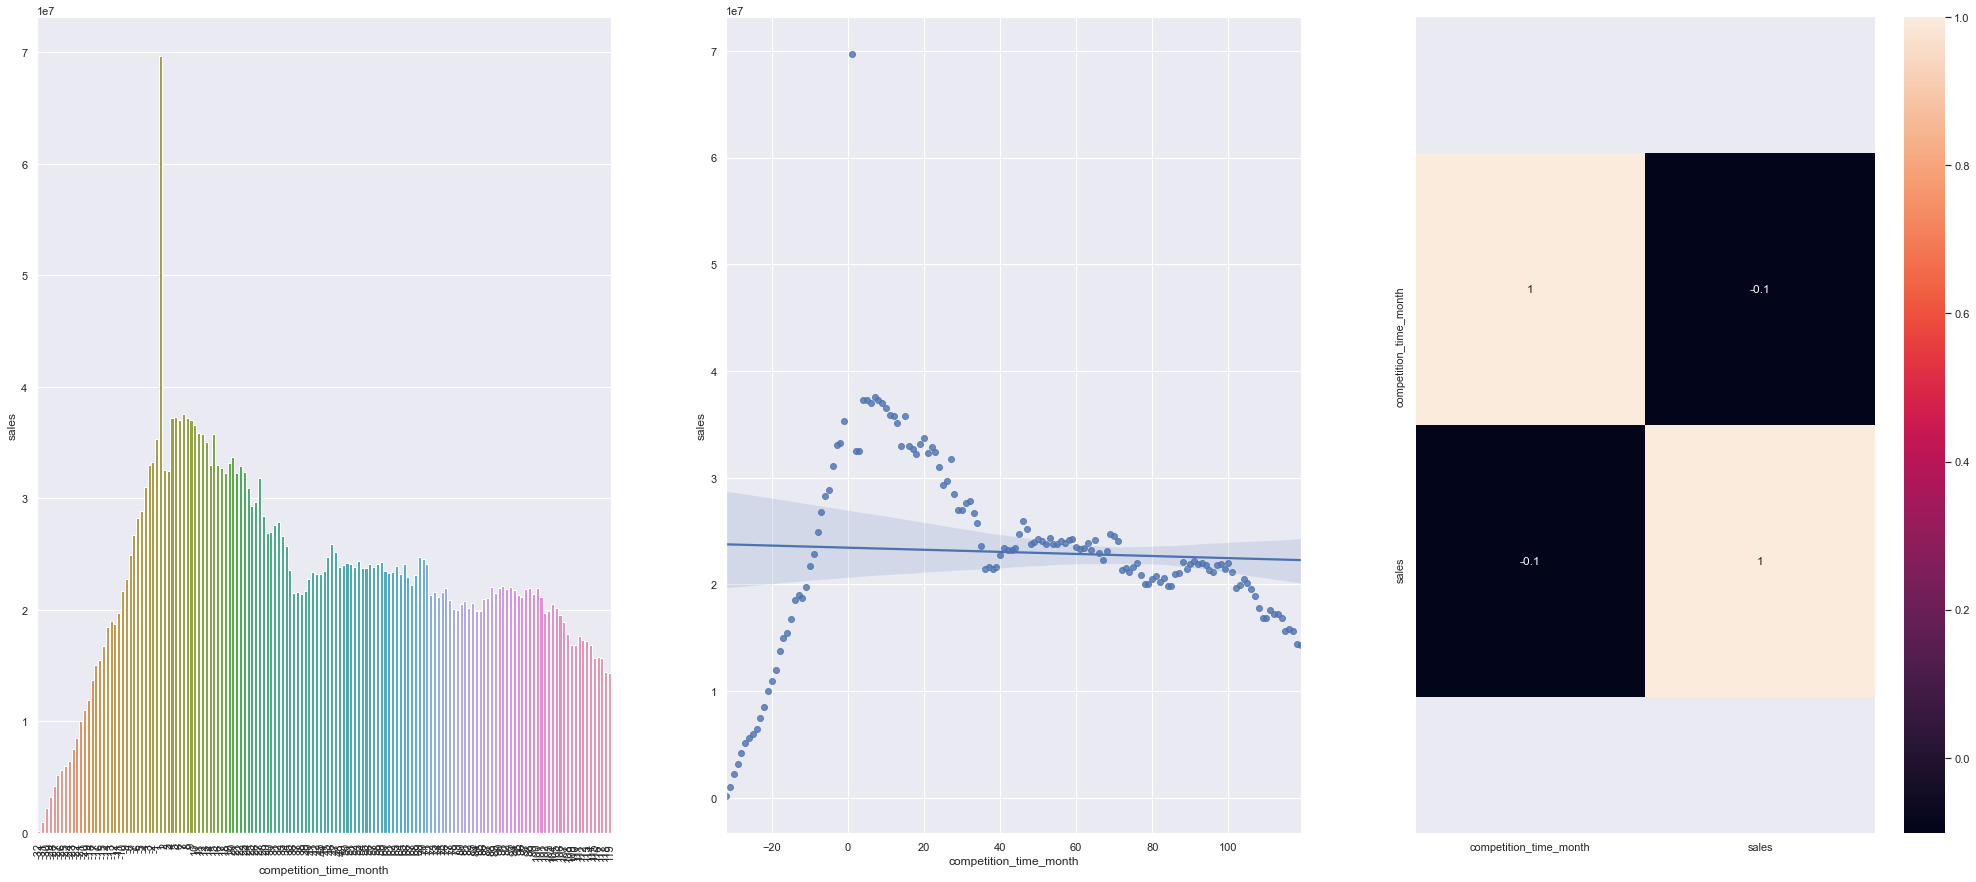

In [39]:
aux1 = df4[ [ 'competition_time_month', 'sales' ] ].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ ( aux1[ 'competition_time_month' ] < 120 ) & ( aux1[ 'competition_time_month' ] != 0 ) ]

plt.figure( figsize=( 35, 15) )
plt.subplot( 1, 3, 1)
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3 ,3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True )
bottom, top = x.get_ylim( )
x.set_ylim( bottom+0.5, top-0.5);

we can see that:
* the more recent a competitor’s store opens, the greater the sales

#### H4. Stores with longer active promotions should sell more
***False*** Stores with active promotions for longer, sell less after a certain promotion period

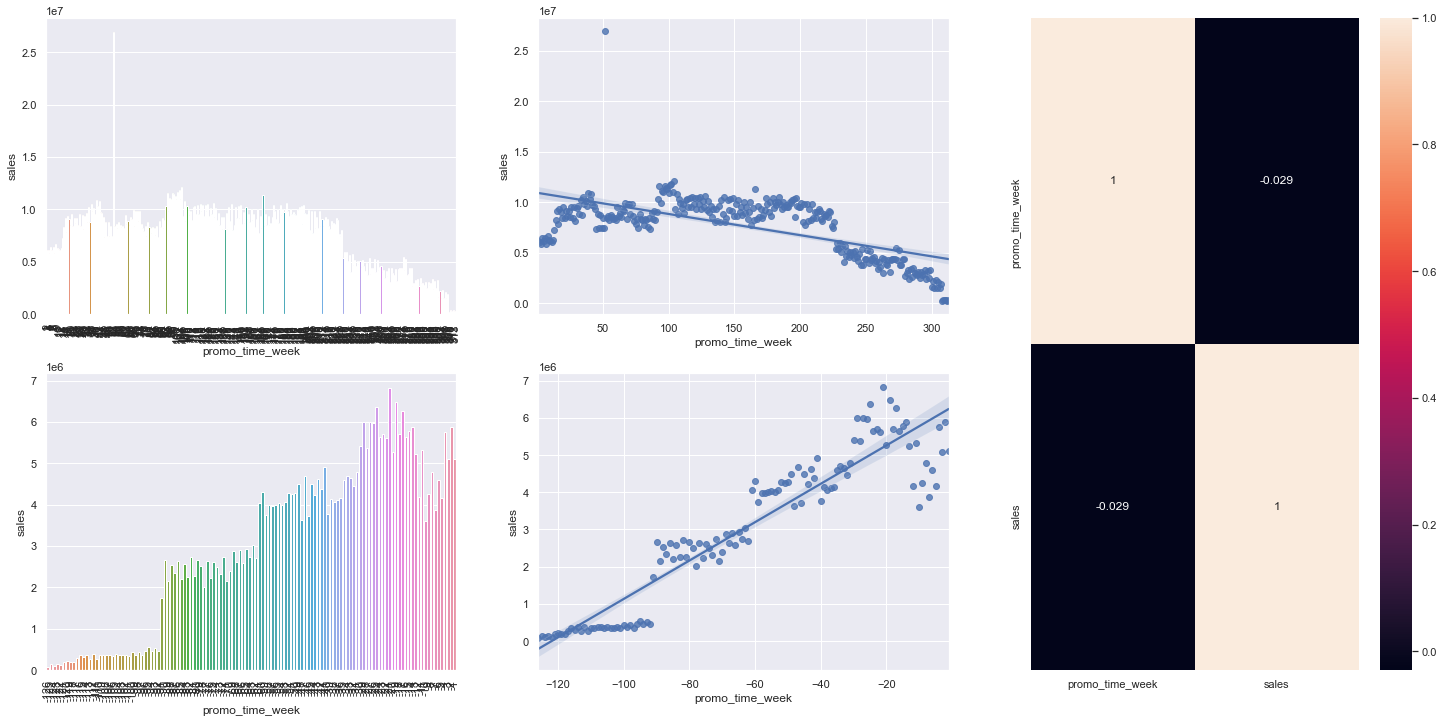

In [40]:
aux1 = df4[[ 'promo_time_week', 'sales' ]].groupby( 'promo_time_week' ).sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[ aux1[ 'promo_time_week' ] > 0 ] # extended promo
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[ aux1[ 'promo_time_week' ] < 0 ] # regular promo
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In 'promo_time_week' bar chart:
* there is a decline in sales over time, which refutes our hypothesis

The correlation is very weak, just because the flat period is much longer than the decay period.

We will have to check the behavior of this feature with other variables, but for now it does not appear to have much relevance to the model.

#### H5. <s> Stores with more promotion days should sell more </s>

#### H6. Stores with more consecutive promotions should sell more
***False*** Stores with more consecutive promotions sell less

In [41]:
# checking sum of promos with groupby promo and promo2
df4[ [ 'promo', 'promo2', 'sales' ] ].groupby( [ 'promo', 'promo2' ] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


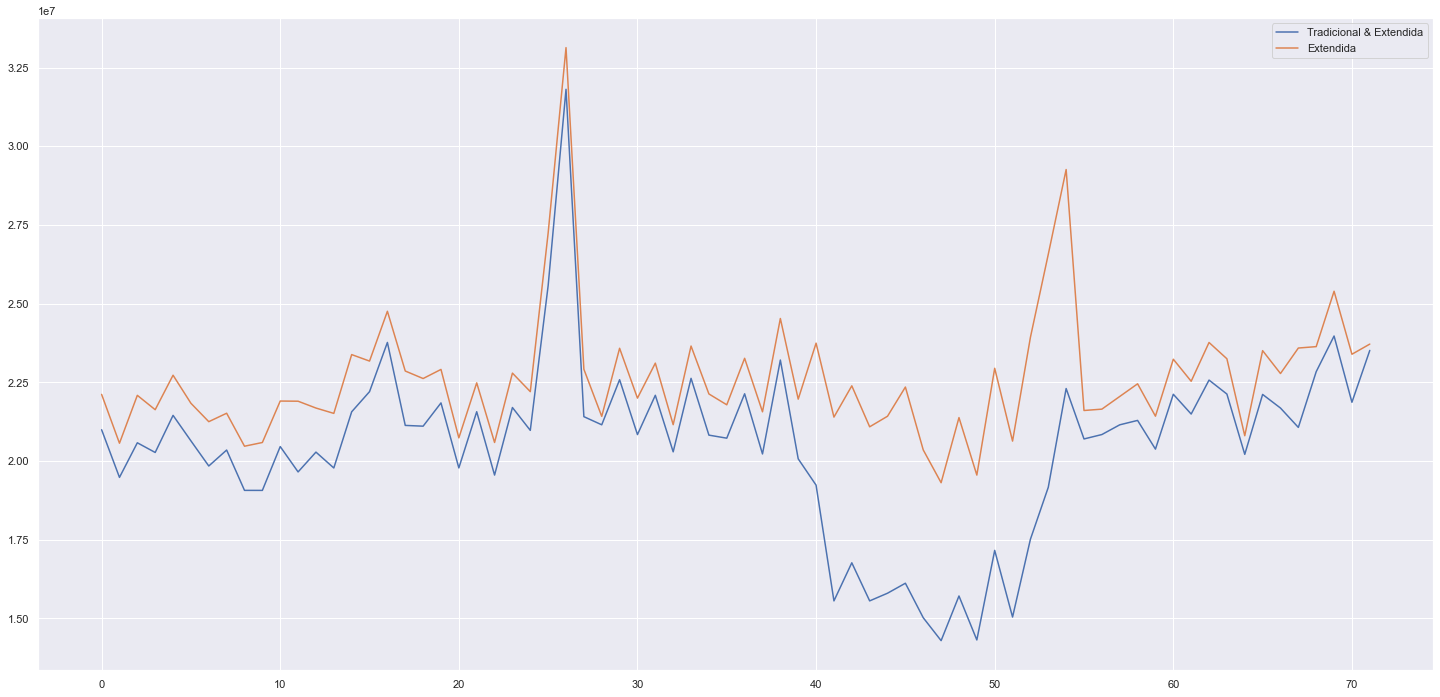

In [42]:
# checking sum of sales that is in promo and that extended (promo2), grouping by year_week 
aux1 = df4[ ( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 1 ) ][[ 'year_week', 'sales' ]].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot();

# checking whether it’s worth getting into the extended promotion
aux2 = df4[ ( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 0 ) ][[ 'year_week', 'sales' ]].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=[ 'Tradicional & Extendida', 'Extendida' ] );

as we can see, in the extended promotion graph, 
* stores with more consecutive promotions sell less and not more. 

Therefore, we **refute** our hypothesis. 

There is a very punctual decline behavior in the region, which extends from 40 to approximately 55, however, the lines do not seem to distort in most of the graph, so there is not a large increase in new information.

We should check the behavior of the feature with the help of some algorithms, for a better analysis. However, for now, the feature does not appear to have much relevance in the model

#### H7. Stores that open during the Christmas holiday should sell more
***False*** Stores that open during the Christmas holiday sell less

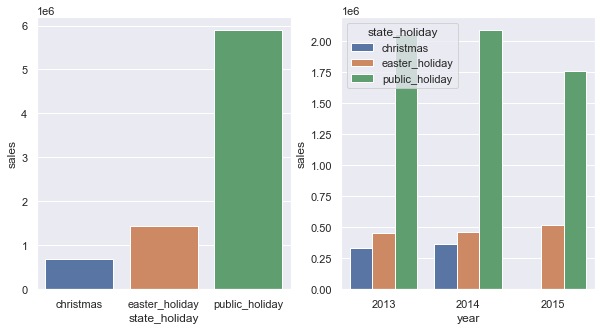

In [43]:
plt.figure( figsize=(10,5) )
plt.subplot( 1, 2, 1 )

# state_holiday sales grouped by state_holiday
aux = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
aux1 = aux[[ 'state_holiday', 'sales' ]].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

# by year
plt.subplot( 1, 2, 2 )
aux2 = aux[[ 'year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday' ] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

As observed, stores that open on Christmas don't sell more.

Thus, we **refute** our hypotesis.

Obs: We don't have the data from Christmas sales for year 2015, because the data ends on July 31st.
Even so, we can consider these variables in our ML model.

#### H8. Stores should sell more over the years
***False*** Stores Sell Less Over the Years

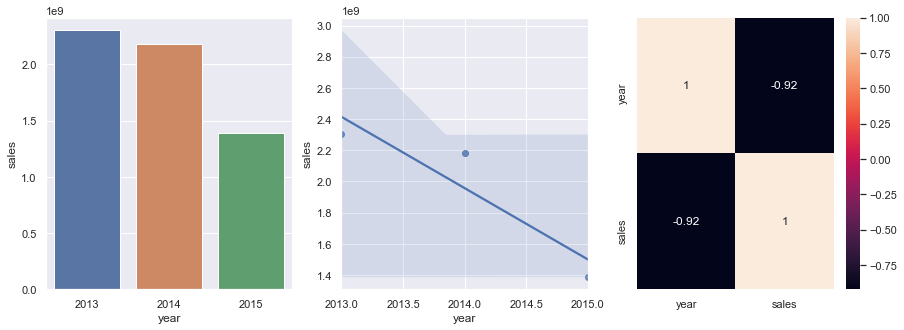

In [44]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

We have a strong negative correlation (-0.92) between year and sales, which suggests that sales do not grow over the years.

Therefore, we **refute** our hypothesis.

#### H11. Stores should sell more in the second half of the year
***False*** stores sell less in the second half of the year

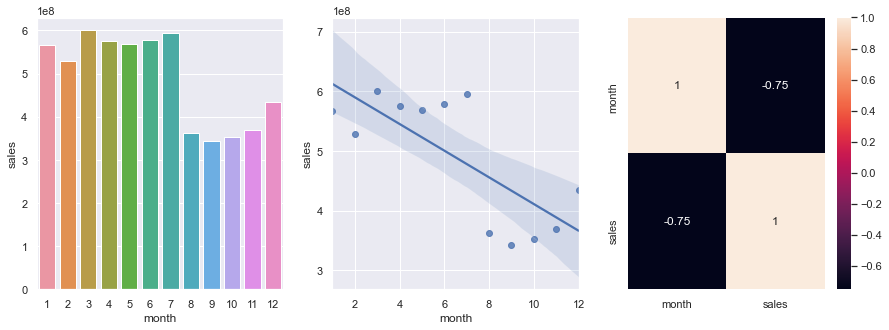

In [45]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

We see a strong negative correlation between months and sales (-0.75). In the second half of the year, there is an increase in sales on the seventh month, but they lose strength over the months, with a very weak result compared to the first half of the year.

Therefore, we **refute** our hypothesis.

#### H12. Stores should sell more after the 10th of each month
***True*** Stores sell more after the 10th of each month

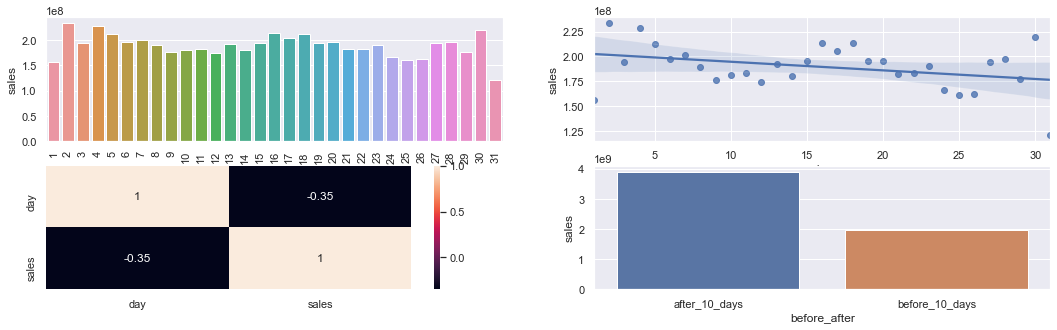

In [46]:
plt.figure( figsize=(18,5) )
plt.subplot( 2, 2, 1 )
aux1 = df4[[ 'day', 'sales']].groupby('day').sum().reset_index()
aux1
sns.barplot(x='day', y='sales', data=aux1 );
plt.xticks( rotation=90 )

plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.subplot( 2, 2, 4 )
aux1[ 'before_after' ] = aux1[ 'day' ].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[[ 'before_after', 'sales' ]].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

We can clearly see the discrepancy between the volume of sales after the tenth day of each month.

Therefore, we **accept** our hypothesis.

Note: Despite the weak correlation, this variable can be important for the model, since it has different sales values before and after the tenth day

#### H13. Stores should sell less on weekends
***True*** Shops sell less on weekends

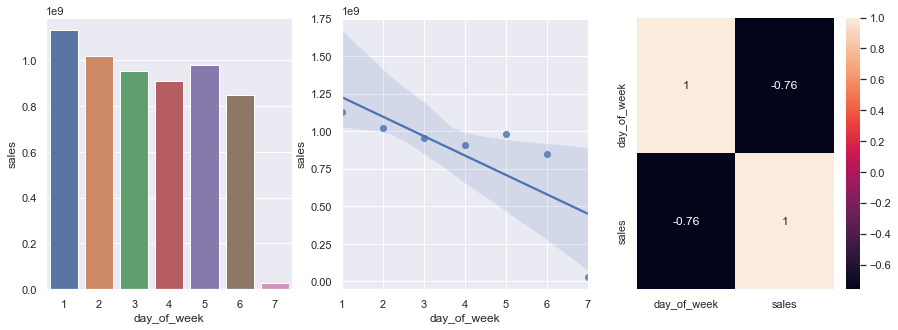

In [47]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

We can see the decline in sales on weekends, with special attention to Sunday (7), the day with the lowest sales throughout the week.

Therefore, we **accept** our hypothesis.

In addition, we can see a strong negative correlation (-0.76) between weekdays and sales.

#### H14. Stores should sell less during school holidays
***True*** Stores sell less during school holidays, except during July and August.

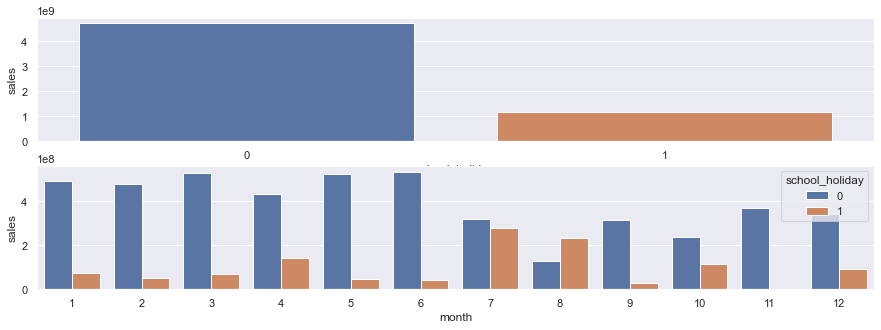

In [48]:
plt.figure( figsize=(15,5) )
plt.subplot( 2, 1, 1 )
aux1 = df4[[ 'school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[[ 'month', 'school_holiday', 'sales' ]].groupby([ 'month', 'school_holiday' ]).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);

We can see that the bar of the graph in orange, referring to sales on the school holiday (1), is much smaller than the blue one, referring to sales on normal days (0).

So we **accept** our hypothesis.

#### Summary of Hypotheses

In [49]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '--', '--'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H11', 'Falsa', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Alta'],
       ['H14', 'Verdadeira', 'Baixa']]

print( tabulate( tab, headers='firstrow' ) )

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          --           --
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H11         Falsa        Alta
H12         Verdadeira   Alta
H13         Verdadeira   Alta
H14         Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

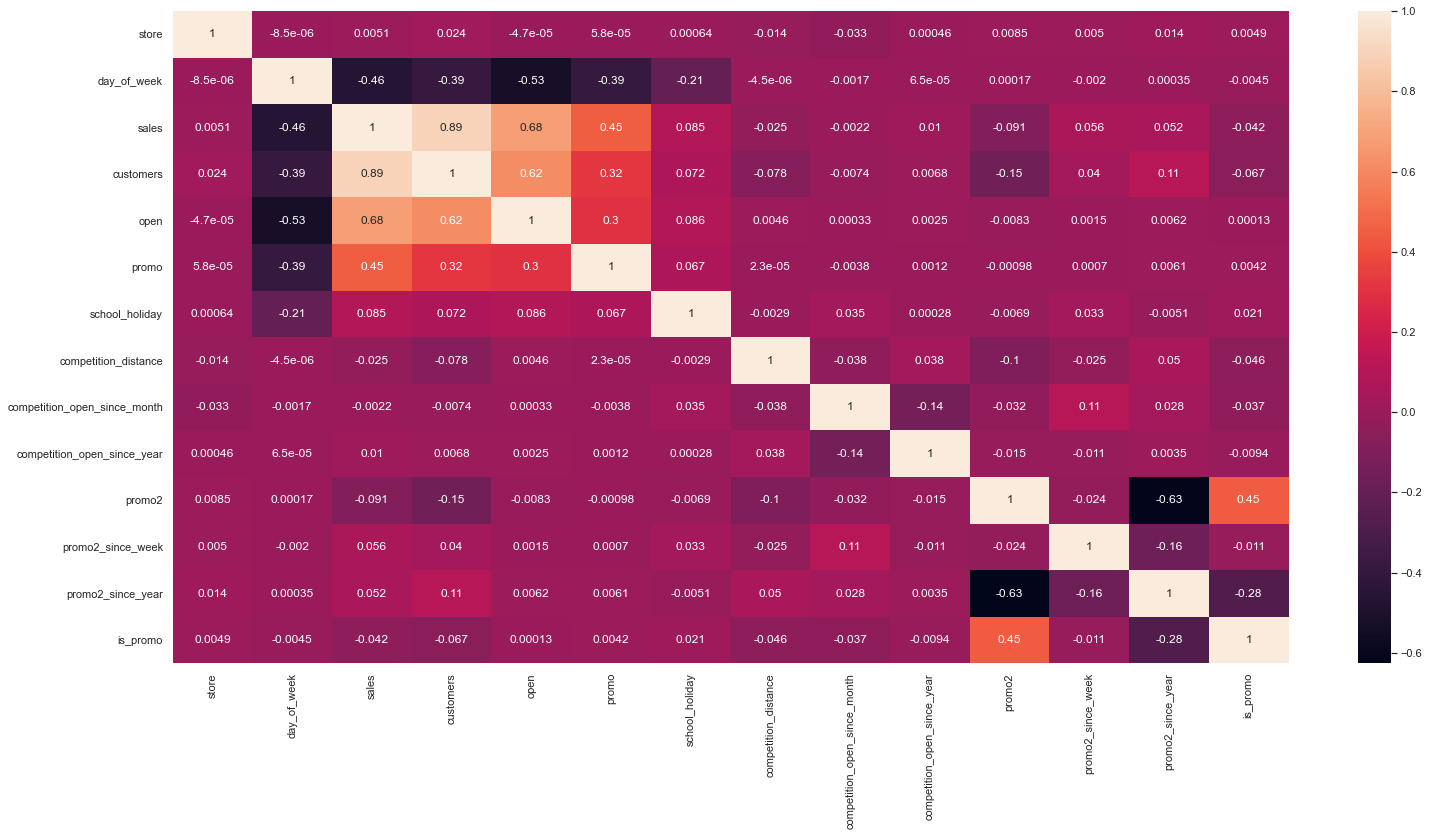

In [50]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.1 Categorical Attributes

In [51]:
# categorical data
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


To compute the correlation between categorical variables, we will use Cramér's V formula:
https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

Cramér's V is computed by taking the square root of the chi-squared statistic divided by the sample size and the minimum dimension minus 1:

$V = \sqrt{\frac{\varphi^2}{\min(k - 1,r-1)}} = \sqrt{ \frac{\chi^2/n}{\min(k - 1,r-1)}}$
where:

* $\varphi$ is the phi coefficient.
* $\chi^2$ is derived from Pearson's chi-squared test
* $n$ is the grand total of observations and
* $k$ being the number of columns.
* $r$ being the number of rows.

Bias correction

Cramér's V can be a heavily biased estimator of its population counterpart and will tend to overestimate the strength of association. A bias correction, using the above notation, is given by:

$\tilde V = \sqrt{\frac{\tilde\varphi^2}{\min(\tilde k - 1,\tilde r - 1)}} $ 

where

$ \tilde\varphi^2 = \max\left(0,\varphi^2 - \frac{(k-1)(r-1)}{n-1}\right) $ 

and

$ \tilde k = k - \frac{(k-1)^2}{n-1} $ 

$ \tilde r = r - \frac{(r-1)^2}{n-1} $ 

Then $\tilde V$ estimates the same population quantity as Cramér's V but with typically much smaller mean squared error. The rationale for the correction is that under independence, $E[\varphi^2]=\frac{(k-1)(r-1)}{n-1}$.

The range of Cramér V is [0 to 1], so we don't have negative correlation. Thus, the closer to zero, the lesser is the correlation and the closer to 1, the higher is the correlation.

* Notes: For a better organization of the code, I separated the Cramérs'V function in the section: "Helper Functions"

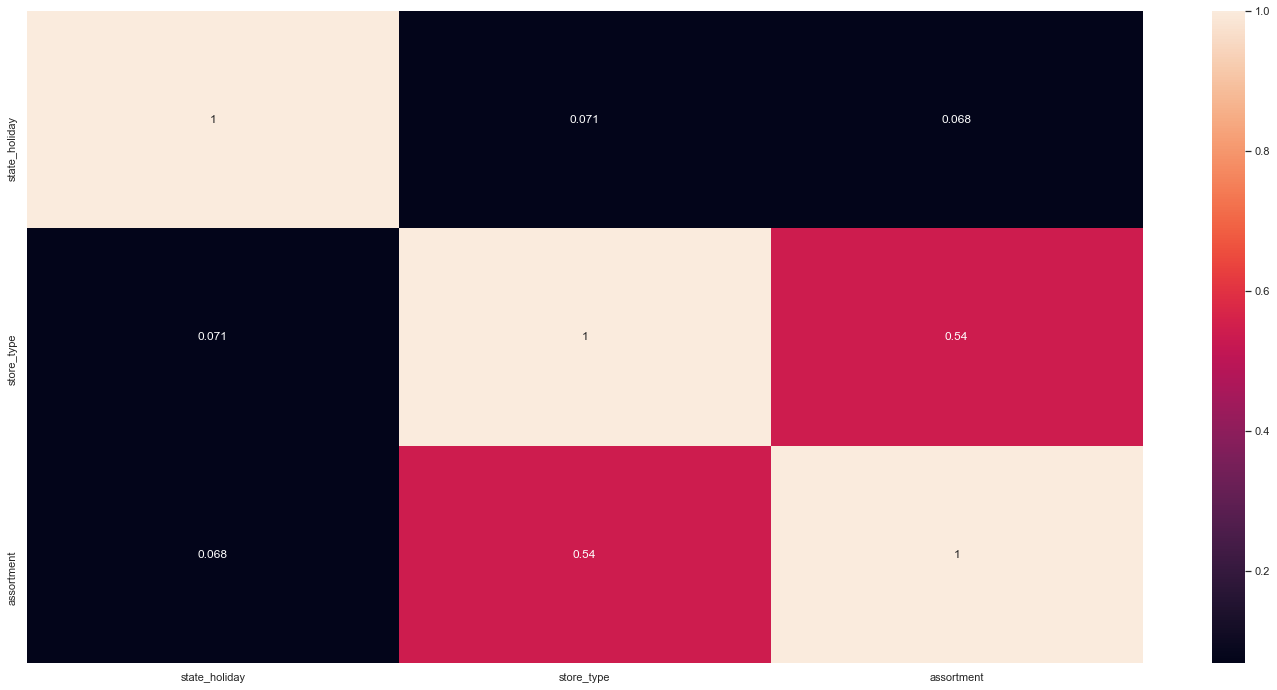

In [52]:
# calculate cramer v
a1 = cramer_v( a[ 'state_holiday'], a[ 'state_holiday' ] )
a2 = cramer_v( a[ 'state_holiday'], a[ 'store_type' ] )
a3 = cramer_v( a[ 'state_holiday'], a[ 'assortment' ] )

a4 = cramer_v( a[ 'store_type'], a[ 'state_holiday' ] )
a5 = cramer_v( a[ 'store_type'], a[ 'store_type' ] )
a6 = cramer_v( a[ 'store_type'], a[ 'assortment' ] )

a7 = cramer_v( a[ 'assortment'], a[ 'state_holiday' ] )
a8 = cramer_v( a[ 'assortment'], a[ 'store_type' ] )
a9 = cramer_v( a[ 'assortment'], a[ 'assortment' ] )

d = pd.DataFrame( { 'state_holiday' : [ a1, a2, a3 ], 
                'store_type' : [ a4, a5, a6 ], 
                'assortment' : [ a7, a8, a9 ]  } )

d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

As we can see, there is a moderate correlation (0.54) between the assortment and store_type.

The bigger the store, the higher is the assortment of its products.

# 5.0 DATA PREPARATION  

In this step, we will focus on modifying the scale of some variables so that there is no bias in the data.

We can divide the transformation into two categories: **Numerical** and **Categorical**.

#### **Numerical variables:**

We will use 5 types of transformation, 3 for predictor variables and 2 for the response variable:

**Transformation for predictor variables:**

One of the roles with this type of transformation is to prevent us from having a discrepancy between numerical data of different greatness.
    
* **Normalization (Standard Score)**: We will use this type of transformation in normally distributed variables. This transformation subtracts the variable from its mean and divides the result by the standard deviation.
* **Min-Max Scaler**: We will use this type of transformation in variables not normally distributed. This transformation subtracts the variable from its mean and divides the result by the subtracted max from the min.
* **Robust Scaler**: We will use this type of transformation in case of distributions with strong outliers. We subtract the variable by the 1st quartile and divide the results by subtracting the 3rd by the 1st quartile

**Transformation for response variable:**

* **Nature change (cyclical)**: We will make a nature change of the "cyclical continuous" type in the response variable letting our machine learning model know that a feature is cyclical
* **Nature change (Log)**: We will make a nature change of the "logarythimc" type in the response variable in order to bring it closer to a normal distribution, which can bring us a better performance of some machine learning models that we will use later

#### **Categorical variables:**

We will use 2 types of modification:

**Transformation for predictor variables:**

* **One Hot Encoding**: Distributes the categories in columns and sets the occurrences to 0 and 1, where 0 means no occurrence and 1 means presence of occurrence.
* **Label Encoding**: Defines, in a new column, a numeric label for each category

In [53]:
df5 = df4.copy()

## 5.1 Normalization

As verified in the EDA step, there is no normally distributed predictor variable, so we will proceed using rescaling.

## 5.2 Rescaling

we will use RobustScaler in competition distance and competition_time_month, due to the strong influence of outliers

As promo_time_week and year do not have problems with outliers, and are not normally distributed, we will leave it to MinMaxScaler

In [54]:
a = df5.select_dtypes( include=[  'int64', 'float64' ] )

In [55]:
# Min-Max Scaler
# Robust Scaler
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5[ 'competition_distance'] = rs.fit_transform( df5[[ 'competition_distance' ]].values )
# save to pickle
pickle.dump( rs, open( 'parameter\competition_distance_scaler.pkl', 'wb' ))

# competition_time_month
df5[ 'competition_time_month'] = rs.fit_transform( df5[[ 'competition_time_month' ]].values )
pickle.dump( rs, open( 'parameter\competition_time_month_scaler.pkl', 'wb' ))

# promo_time_week
df5[ 'promo_time_week'] = mms.fit_transform( df5[[ 'promo_time_week' ]].values )
pickle.dump( rs, open( 'parameter\promo_time_week_scaler.pkl', 'wb' ))
# year
df5[ 'year'] = mms.fit_transform( df5[[ 'year' ]].values )
pickle.dump( mms, open( 'parameter\year_scaler.pkl', 'wb' ))

## 5.3 Transformation

In this step, we will do a character encoding in our categorical predictor variables.

This is important for our machine learning models below, which need a numerical representation for the calculation

### 5.3.1 Encoding

In [56]:
# state_holiday - One Hot Enconding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5[ 'store_type' ] = le.fit_transform( df5[ 'store_type' ] )

# save to pickle
pickle.dump( le, open( 'parameter\store_type_scaler.pkl', 'wb' ))

# assortment - Ordinal Encoding
assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
df5[ 'assortment' ] = df5[ 'assortment' ].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [57]:
# log Transformation
df5[ 'sales' ] = np.log1p( df5[ 'sales' ] )

### 5.3.3 Nature Transformation

In this step, we need to let the machine learning model know that the feature has a continuous / cyclical nature because its occurrence is defined in months, which are repeated every year.

We can solve this by calculating the rotation of the months in trigonometric terms.

In [58]:
# month
df5[ 'month_sin' ] = df5[ 'month' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5[ 'month_cos' ] = df5[ 'month' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# day
df5[ 'day_sin' ] = df5[ 'day' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 ) ) )
df5[ 'day_cos' ] = df5[ 'day' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )

# day_of_week
df5[ 'day_of_week_sin' ] = df5[ 'day_of_week' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
df5[ 'day_of_week_cos' ] = df5[ 'day_of_week' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

# week_of_year
df5[ 'week_of_year_sin' ] = df5[ 'week_of_year' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
df5[ 'week_of_year_cos' ] = df5[ 'week_of_year' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )

# 6.0 FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1 Split dataset into training and test dataset

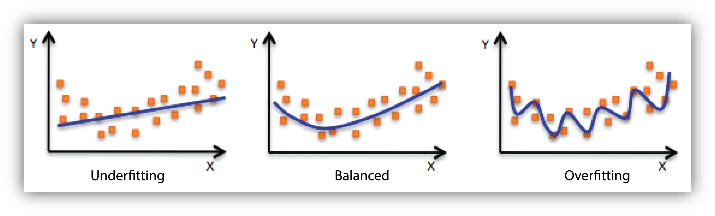

In [60]:
Image("https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/images/mlconcepts_image5.png")

From now on, we will be concerned with dividing our data in two groups: Training and Testing (in the hope of preventing over and under fiting of the data)

In [61]:
# keep only the transformed columns and delete the previous ones
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [62]:
df6[[ 'store', 'date' ]].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

It’s convenient to think that our test data should be the last 6 weeks of sales, as the goal is to forecast sales in that period. Therefore, we can separate these data by subtracting 6 weeks from the max date.

In [63]:
# training dataset
X_train = df6[ df6[ 'date' ] < '2015-06-19' ]
Y_train = X_train[ 'sales' ]

# test dataset
X_test = df6[ df6[ 'date' ] >= '2015-06-19' ]
Y_test = X_test[ 'sales' ]

print( 'Training Min Date: {}'.format( X_train[ 'date' ].min() ) )
print( 'Training Max Date: {}'.format( X_train[ 'date' ].max() ) )

# the test data is the last 6 weeks
print( '\nTest Min Date: {}'.format( X_test[ 'date' ].min() ) )
print( 'Test Max Date: {}'.format( X_test[ 'date' ].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

### 6.2.1 Best Features from Boruta

In [76]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 );
cols_selected_boruta =  X_train_fs.iloc[ :, cols_selected ].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) ) # difference between two sets;

## 6.3 Manual Feature Selection

After the Boruta selection process, we have the best features for our models

In [65]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = [ 'date', 'sales' ]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

cols_selected_boruta


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 MACHINE LEARNING MODELING

In [66]:
# our test and training data with the features chosen by the boruta
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1 Average Model

We will use the average model as a baseline for the following models.

In [67]:
aux1 = x_test.copy()
aux1[ 'sales' ] = Y_test.copy()

# predictions
aux2 = aux1[[ 'store', 'sales' ]].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales' : 'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1[ 'predictions' ]

# performance
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,MODEL NAME,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [68]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,MODEL NAME,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


The RMSE error of the linear model is greater than the RMSE of the average model. This indicates a possible non-linear relationship between the variables.

### 7.2.1 Linear Regression Model - Cross Validation  

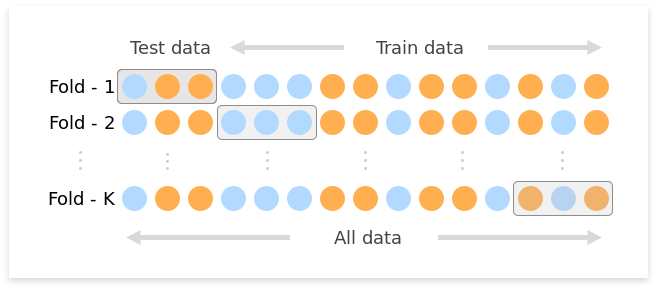

In [69]:
Image("img/k-fold.png")

We will do a Cross Validation process, to prevent biased results in our models.

***The Cross Validation process involves:***
    
1. Mix the data set randomly.
2. Divide the data set into groups k

***For each unique group:***
    
1. Take the group as a support or data set test
2. Considers the remaining groups as a set of training data
3. Fit a model in the training set and evaluate with the test set
4. Estimates the error and reserve

At the end of all iterations, calculate the average error of the resulting list of errors

In [70]:
# entire dataset for cross validation
x_training = X_train[cols_selected_boruta_full]

In [71]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

In [72]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [73]:
# model
lrr = Lasso( alpha = 0.01 ).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,MODEL NAME,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Lasso - Cross Validation  

In [74]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )

In [75]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


## 7.4 Random Forest Regressor

In [76]:
# model
rf = RandomForestRegressor(n_estimators=100, 
                           n_jobs=-1, 
                           random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,MODEL NAME,MAE,MAPE,RMSE
0,Random Forest Regressor,677.792157,0.099696,1008.178845


### 7.4.1 Random Forest Regressor - Cross Validation

In [77]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.51 +- 218.18,0.12 +- 0.02,1256.61 +- 319.26


## 7.5 XGBoost Regressor

In [80]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=3000, 
                              eta=0.031, 
                              max_depth=5, 
                              subsample=0.3, 
                              colsample_bytree=0.9,
                              min_child_weight=8 ).fit(x_train, Y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,MODEL NAME,MAE,MAPE,RMSE
0,XGBoost Regressor,754.131267,0.113315,1083.652276


### 7.5.1 XGBoost Regressor - Cross Validation

In [81]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [84]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,933.1 +- 123.49,0.13 +- 0.01,1330.55 +- 166.64


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [82]:
modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modeling_result.sort_values( 'RMSE' )

,MODEL NAME,MAE,MAPE,RMSE
0,Random Forest Regressor,677.792157,0.099696,1008.178845
0,XGBoost Regressor,754.131267,0.113315,1083.652276
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


As we can see, the random forest is the model that has the least error. However, we also need to analyze their real performance, as well as that of the other models, through the cross-validation process.

### 7.6.2 Real Performance - Cross Validation

In [89]:
modeling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.51 +- 218.18,0.12 +- 0.02,1256.61 +- 319.26
0,XGBoost Regressor,933.1 +- 123.49,0.13 +- 0.01,1330.55 +- 166.64
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


* We can see that the Random Forest model continues with the smallest error among all models, followed by XGBoost. Apparently, non-linear models seem to better explain the phenomenon of sales.

* Despite the data indicating Random Forest as having the best performance, we will continue with XGBoost.

* The marginal performance gain of Random Forest compared to XGBoost, does not justify its memory consumption when the model is allocated. Therefore, we will continue with XGBoost.

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

We will use the Random Search method, which consists of randomly combining a given set of parameters, in an attempt to better adjust the model parameters and reduce the error.

In [151]:
param = { 'n_estimators' : [1500, 1700, 2500, 3000, 3500],
          'eta' : [0.01, 0.03],
          'max_depth' : [3, 5, 9],
          'subsample' : [0.1, 0.5, 0.7],
          'colsample_bytree' : [0.3, 0.7, 0.9],
          'min_child_weight' : [3, 8, 15]
         }

MAX_EVAL = 5    

[3500, 0.03, 5, 0.1, 0.7, 3]

In [152]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()} 
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'],  
                                 subsample=hp['subsample'], 
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight']).fit(x_train, Y_train)

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

K

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,789.41 +- 121.98,0.11 +- 0.01,1141.26 +- 185.35
0,XGBoost Regressor,1658.76 +- 173.17,0.23 +- 0.01,2388.28 +- 225.13
0,XGBoost Regressor,816.33 +- 116.77,0.11 +- 0.01,1171.83 +- 168.08
0,XGBoost Regressor,1424.67 +- 143.33,0.2 +- 0.01,2063.6 +- 186.39
0,XGBoost Regressor,1582.97 +- 165.78,0.22 +- 0.01,2282.37 +- 211.56


## 8.2 Final Model

In [90]:
# after a few attempts 
# best parameters found by random search
param_tuned = { 'n_estimators' : 3000,
                'eta' : 0.031,
                'max_depth' : 5,
                'subsample' : 0.3,
                'colsample_bytree' : 0.9,
                'min_child_weight' : 8
        }

In [91]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=param_tuned[ 'n_estimators' ], 
                              eta=param_tuned[ 'eta' ], 
                              max_depth=param_tuned[ 'max_depth' ], 
                              subsample=param_tuned[ 'subsample' ], 
                              colsample_bytree=param_tuned[ 'colsample_bytree' ],
                              min_child_weight=param_tuned[ 'min_child_weight' ]).fit(x_train, Y_train)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ))
xgb_result_tuned

,MODEL NAME,MAE,MAPE,RMSE
0,XGBoost Regressor,754.131267,0.113315,1083.652276


# 9.0 ERROR TRANSLATION AND INTERPRETATION

In [156]:
df9 = X_test[cols_selected_boruta_full]

# rescale back

df9[ 'sales' ] = np.expm1( df9[ 'sales' ] )
df9[ 'predictions' ] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance 

In [157]:
# Sum of Predictions
df91 = df9[[ 'store', 'predictions' ]].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[[ 'store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={ 0 : 'MAE'} )
df9_aux2 = df9[[ 'store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={ 0 : 'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )

# Final DataFrame Merged
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92[ 'worst_scenario' ] = df92[ 'predictions' ] - df92[ 'MAE' ]
df92[ 'best_scenario' ] = df92[ 'predictions' ] + df92[ 'MAE' ]

# Order Columns
df92 = df92[[ 'store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

In [158]:
# Sorted MAPE descending 
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107780.773438,104422.493986,111139.052889,3358.279451,0.591244
908,909,221877.625000,213970.105087,229785.144913,7907.519913,0.521855
875,876,196182.578125,192128.613706,200236.542544,4053.964419,0.328727
169,170,199086.250000,197807.628108,200364.871892,1278.621892,0.317209
901,902,193622.312500,192386.790514,194857.834486,1235.521986,0.308995


Some stores, such as 292, are extremely difficult to forecast. Notice the MAPE of almost 0.6. This is not a very satisfactory result. We can try to work on this problem in a new round of CRISP, because for now, the model is already very functional and we need to deliver value quickly to the business team.

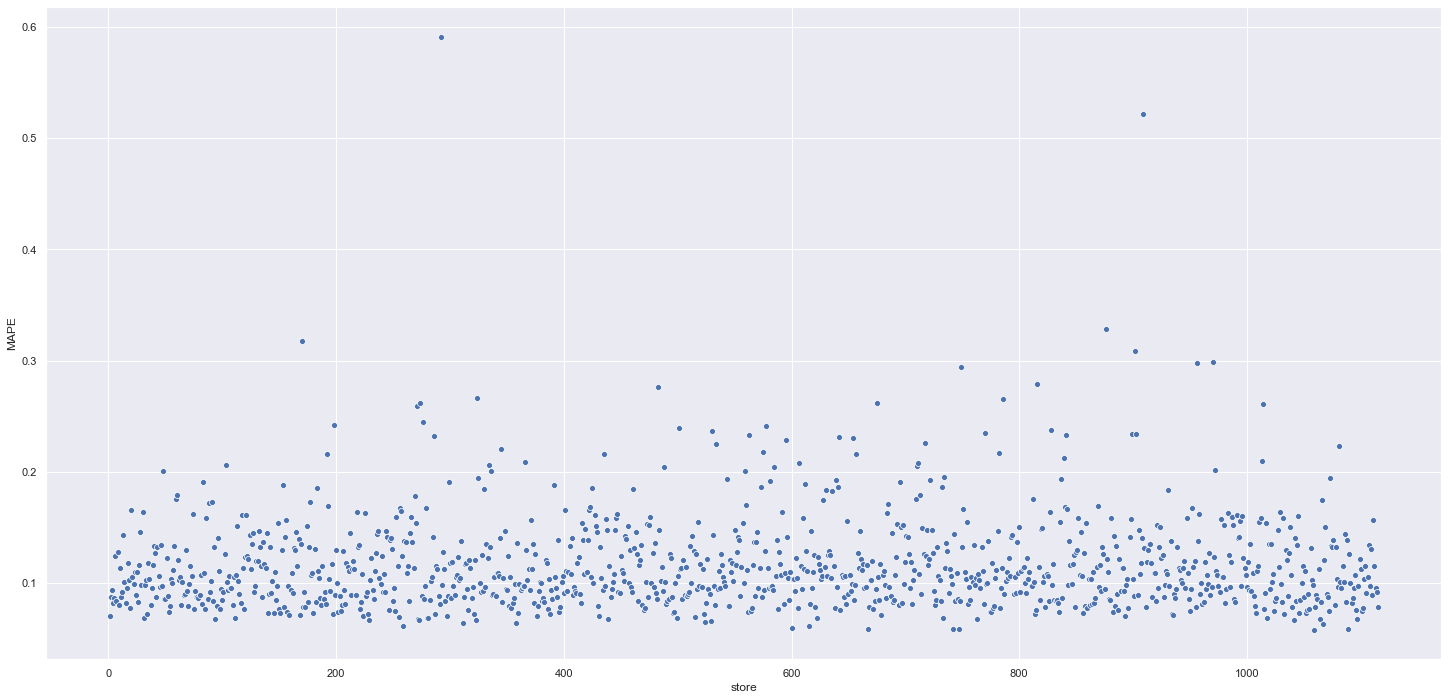

In [159]:
# Store x MAPE analysis
sns.scatterplot( x='store', y='MAPE', data=df92 );

In the graph, we can see some stores with an outlier aspect. These, in particular, have a larger MAPE error and, therefore, have a more difficult predictability.

## 9.2 Total Performance

In [160]:
df93 = df92[[ 'predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: numpy.sum( x ), axis=0 ).reset_index().rename( columns={ 'index' : 'scenario', 0 : 'values'} )
df93[ 'values' ] = df93[ 'values' ].map( 'R${:,.2f}'.format) 
df93

,scenario,values
0,predictions,"R$285,971,136.00"
1,worst_scenario,"R$285,105,989.34"
2,best_scenario,"R$286,836,280.58"


## 9.3 Machine Learning Performance

In [161]:
df9[ 'error' ] = df9[ 'sales' ] - df9[ 'predictions' ]
df9[ 'error_rate' ] = df9[ 'predictions' ] / df9[ 'sales' ]

<AxesSubplot:xlabel='predictions', ylabel='error'>

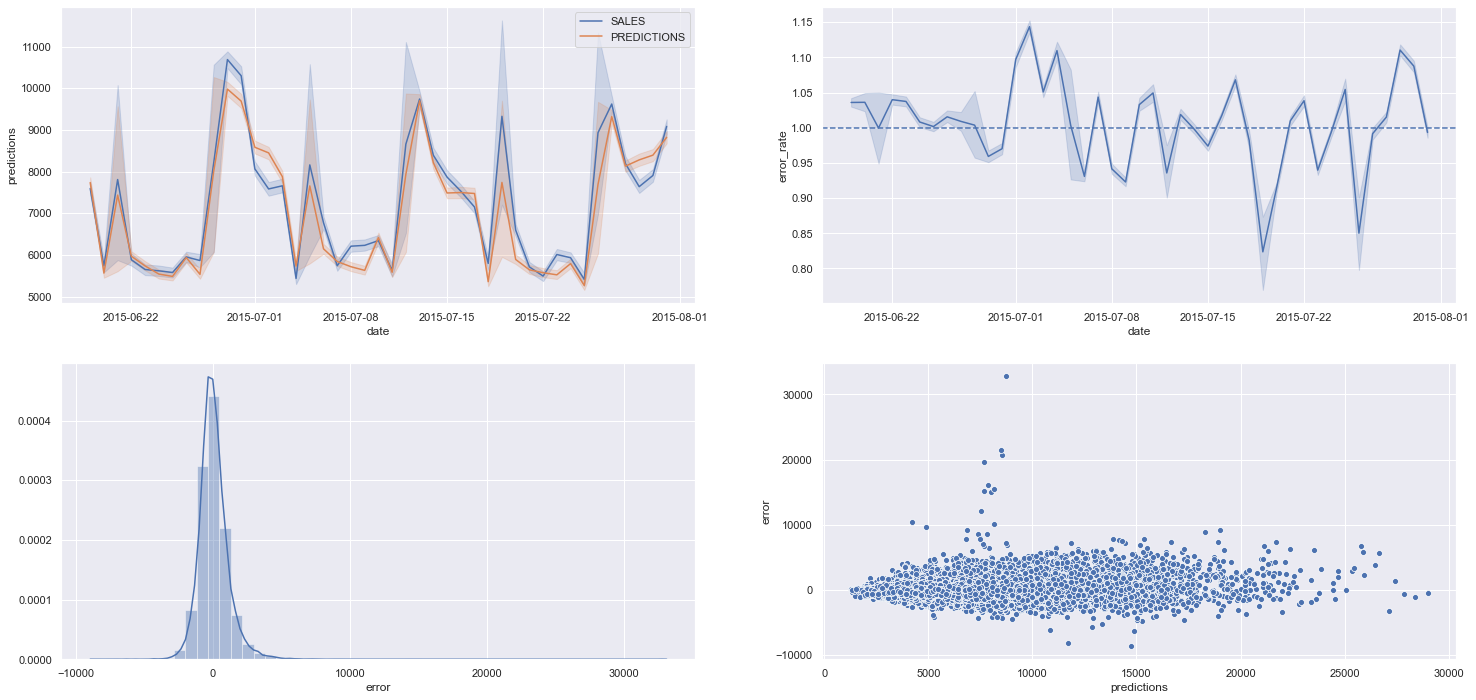

In [162]:
plt.subplot( 2, 2, 1 )
# sales x predicted sales
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
# error_rate per day
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline(1, linestyle='--')


plt.subplot( 2, 2, 3 )
# error dist
sns.distplot( df9[ 'error' ] )

# error for each predicted sale
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9[ 'predictions' ], df9[ 'error' ] )

How can we see:

* The first graph shows that our forecasts are very close to the real values.

* The error rate has a more volatile variation over time, but still an acceptable proportion error rate.

* The histogram shows an approximately normal distribution for the error.

* The scatter plot demonstrates a horizontal "tube" shape (with some major variations in error between 5000 to 10000) and therefore validates a good "health" of our model.

# 10.0 DEPLOY MODEL TO PRODUCTION

In [ ]:
# Saving the model to pickle
pickle.dump(model_xgb_tuned, open('model\model_rossman.pkl', 'wb'))

In [116]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

## 10.1 Rossmann Class

class Rossmann( object ):
    
    def __init__( self ):
        
        # load data
        self.home_path = 'C:\\Users\\Usuário\\Documents\\repos\\DataScience_Em_Producao_Treino\\'
        self.competition_distance_scaler =   pickle.load( open( self.home_path + 'parameter\competition_distance_scaler.pkl', 'rb' ))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter\competition_time_month_scaler.pkl', 'rb' ))
        self.promo_time_week_scaler =        pickle.load( open( self.home_path + 'parameter\promo_time_week_scaler.pkl', 'rb' ))
        self.year_scaler =                   pickle.load( open( self.home_path + 'parameter\year_scaler.pkl', 'rb' ))
        self.store_type_scaler =             pickle.load( open( self.home_path + 'parameter\store_type_scaler.pkl', 'rb' ))

        
    def data_cleaning( self, df1 ):
        
        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        #rename
        df1.columns = cols_new

        ## 1.3 Data Types

        df1[ 'date' ] = pd.to_datetime( df1[ 'date' ] )

        ## 1.5 Fillout NA
        # competition_distance  
        df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month
        df1[ 'competition_open_since_month' ] = df1.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ], axis=1 )

        # competition_open_since_year 
        df1[ 'competition_open_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ], axis=1 )

        # promo2_since_week 
        df1[ 'promo2_since_week' ] = df1.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ], axis=1 )

        # promo2_since_year 
        df1[ 'promo2_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ], axis=1 )

        # promo_interval 
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1[ 'promo_interval' ].fillna( 0, inplace=True )

        df1[ 'month_map' ] = df1[ 'date' ].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x[ 'promo_interval' ] == 0 else 1 if x[ 'month_map' ] in x[ 'promo_interval' ].split( ',' ) else 0, axis=1 )

        ## 1.6 Change Types

        # changing float types to int
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')  
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    

    def feature_engineering( self, df2 ):

        # year
        df2[ 'year' ] = df2[ 'date' ].dt.year

        # month 
        df2[ 'month' ] = df2[ 'date' ].dt.month

        # day
        df2[ 'day' ] = df2[ 'date' ].dt.day

        # week of year
        df2[ 'week_of_year' ] = df2[ 'date' ].dt.weekofyear

        # year week
        df2[ 'year_week' ] = df2[ 'date' ].dt.strftime( '%Y-%W' )

        # competition since
        df2[ 'competition_since' ] = df2.apply( lambda x: datetime.datetime(year=x[ 'competition_open_since_year' ], month=x[ 'competition_open_since_month' ], day=1), axis=1 )
        df2[ 'competition_time_month' ] = ( ( df2[ 'date' ] - df2[ 'competition_since' ] ) / 30 ).apply( lambda x: x.days).astype( 'int64' )

        # promo since
        df2[ 'promo_since' ] = df2[ 'promo2_since_year' ].astype( str ) + '-' + df2[ 'promo2_since_week' ].astype( str )
        df2[ 'promo_since' ] = df2[ 'promo_since' ].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
        df2[ 'promo_time_week' ] = ( ( df2[ 'date' ] - df2[ 'promo_since' ] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )

        # assortment
        df2[ 'assortment' ] = df2[ 'assortment' ].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2[ 'state_holiday' ] = df2[ 'state_holiday' ].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        # 3.0 FILTERING VARIABLES
        ## 3.1 Rows

        df2 = df2[ df2[ 'open' ] != 0 ]

        ## 3.2 Columns Selection

        drop_cols = [ 'open', 'promo_interval', 'month_map' ]
        df2 = df2.drop( drop_cols, axis=1 )

        return df2

    def data_preparation( self, df5, ):
        
        # competition_distance
        df5[ 'competition_distance'] = self.competition_distance_scaler.fit_transform( df5[[ 'competition_distance' ]].values )

        # competition_time_month
        df5[ 'competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[[ 'competition_time_month' ]].values )

        # promo_time_week
        df5[ 'promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[[ 'promo_time_week' ]].values )

        # year
        df5[ 'year'] = self.year_scaler.fit_transform( df5[[ 'year' ]].values )

        ## 5.3 Transformation
        ### 5.3.1 Encoding

        # state_holiday - One Hot Enconding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5[ 'store_type' ] = self.store_type_scaler.fit_transform( df5[ 'store_type' ] )
      
        # assortment - Ordinal Encoding
        assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
        df5[ 'assortment' ] = df5[ 'assortment' ].map( assortment_dict )

        ### 5.3.3 Nature Transformation
        # month
        df5[ 'month_sin' ] = df5[ 'month' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
        df5[ 'month_cos' ] = df5[ 'month' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

        # day
        df5[ 'day_sin' ] = df5[ 'day' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 ) ) )
        df5[ 'day_cos' ] = df5[ 'day' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )

        # day_of_week
        df5[ 'day_of_week_sin' ] = df5[ 'day_of_week' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
        df5[ 'day_of_week_cos' ] = df5[ 'day_of_week' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

        # week_of_year
        df5[ 'week_of_year_sin' ] = df5[ 'week_of_year' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
        df5[ 'week_of_year_cos' ] = df5[ 'week_of_year' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )
        
        # cols selected boruta
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
            'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','month_sin','month_cos','day_sin','day_cos',
            'day_of_week_sin','day_of_week_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data[ 'prediction' ] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso')

## 10.2  API Handler

In [117]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:\\Users\\Usuário\\Documents\\repos\\DataScience_Em_Producao_Treino\\model\\model_rossman.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

# endpoint
@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys()) # multiple example
        
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, minetype='application/json' )
    

if __name__ == '__main__':
    app.run('localhost')

ModuleNotFoundError: No module named 'rossmann'

## 10.1 API Tester

In [217]:
# loading test dataset

df10 = pd.read_csv( 'data/test.csv')

In [218]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[ df_test['Store'].isin( [20, 12, 22] ) ]

# remove closed days
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )

In [219]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records') )

In [220]:
# API call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-psvinniy.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post( url, data=data, headers=header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [221]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [222]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len(d2) ):
    print( 'Store Numer {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store' ],
            d2.loc[i, 'prediction']))

Store Numer 12 will sell R$226,855.44 in the next 6 weeks
Store Numer 20 will sell R$341,344.21 in the next 6 weeks
Store Numer 22 will sell R$129,925.20 in the next 6 weeks
